# Characterizing the behavior of the Cortex only model

Training cortex only model, either continually learned or shuffled data learned.
TEsting the behavioral response to a few specific means, 
and testing the switching dynamics

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import os, sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 8
# mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 6

import utils.plot_utils as pltu
from logger import *
from utils.plot_utils import *
from plot_functions import *
from configs import *
from models.model_lstm import *
import tasks.generative_1d
from tasks.generative_1d import *
from train import *
# from plot_functions import plot_behavior_novel_contexts, plot_histograms_novel_contexts
# from plot_functions import plot_combined_behavior_and_histograms
from plot_functions import *

default_mean1 = 0.3
default_mean2 = 0.7
default_std = 0.3
default_std_novel = 0.2
means = np.array(list(range(-2, 13)))/10
stds = [0.1, 0.2, 0.3, 0.4, 0.5]


# Cortex RNN

In [3]:
def adapt_model_v2_shuff_new_baseline(model, env, _use_oracle, config, optimizer, horizon, criterion, ts_in_training, logger, _use_optimized_thalamus=False, bayesian_likelihoods=None, bayesian_posteriors=None):
    logger.horizon = horizon
    accuracies = []
    _use_oracle = _use_oracle
    obs_buffer = []
    done = False
    while not done:
        obs, reward, done, info = env.step(0)
        obs_buffer.append(obs)
    obs_buffer = np.array(obs_buffer)
    obs_buffer = torch.from_numpy(obs_buffer).float().to(model.device)

    for i in range (len(obs_buffer)):
        idx = np.random.randint(0, len(obs_buffer) - horizon-1)
        horizon_obs = obs_buffer[idx:idx+horizon].squeeze(1)
                # horizon_obs = torch.from_numpy(np.stack(horizon_obs).squeeze(1)).float().to(model.device)

        obs = obs_buffer[idx+horizon].squeeze(1)
        thalamic_inputs = torch.ones(horizon, obs.shape[1], config.thalamus_size).float().to(model.device)/config.thalamus_size

        model.hidden = (torch.zeros_like(model.hidden[0]), torch.zeros_like(model.hidden[1]))

        output, hidden = model(input=horizon_obs, reward=None, thalamic_inputs=thalamic_inputs)
        optimizer.zero_grad()
        target = torch.cat((horizon_obs, obs.unsqueeze(0)), axis=0)[1:]
        if config.l2_loss:
            loss = criterion(output, target) + float(config.l2_loss) * torch.norm(model.thalamus)
        else:
            loss = criterion(output, target)
        loss.backward()
        if bayesian_likelihoods is not None:
            thalamus_grads = torch.from_numpy(bayesian_likelihoods).float().to(model.device)
            model.thalamus.grad = thalamus_grads
        optimizer.step()

        # update info with the gradient of the model thalamus. Since model.thlalamus is len seq, take only last timestep
        if model.thalamus.grad is not None:
            info.update({'thalamus_grad': model.thalamus.grad[-1:].detach().clone().cpu().numpy()})
        info.update({'thalamus': model.thalamus[-1:].detach().cpu().numpy()})
        info.update({'obs': obs.detach().cpu().numpy()})
        info.update({'predictions': output[-1:].detach().cpu().numpy(),
                     'hidden': [h.detach().cpu().numpy() for h in hidden], 'loss': criterion(output[-1:], obs).item(), })
        logger.log_all(info)

        accuracies.append(0)
        # obs_buffer = obs_buffer[5:]

    logger.log_tests({'accuracies': accuracies, 'timestep_i': ts_in_training})
    return (logger, np.stack(logger.timestep_data['loss']))

In [4]:
#Test generalization:
def run_exp_switching_RNN(model, _use_optimized_thalamus=False):
    _use_oracle = False
    
    config= Config(context_units=2)
    config.default_mean1 = default_mean1
    config.default_mean2 = default_mean2
    config.default_std = 0.2 # lower to make the base context switching to easier

    scale = 10
    training_phase_1_config = {'context_transition_function':'base_block_alternating',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 16*20}
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    logger.experiment_name = f'quantifying_generalization_{_use_oracle}'

    env = Generative_environment(config, experiment=6, novel_mean = default_mean2) 
    horizon =10
    optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.000050, momentum=0.5)
    criterion = nn.MSELoss(reduction='sum')
    
    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        0, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    plot_behavior(memory_buffer, env, losses, config, _use_oracle )
    # get the first axis of the plotted figure
    ax = plt.gcf().axes[0]
    ax.set_xlim([0,750])
    if _use_optimized_thalamus: plot_grads(memory_buffer, env, )

    return memory_buffer, losses, env
# This goes through a series of distributions deterministicaly to plot model performances:
def run_exp_generalization_behavior_metrics_RNN(model, _use_optimized_thalamus=False):
    _use_oracle = False
    
    config= Config(env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std}, 'gauss2': {'mean': default_mean2, 'std': default_std},
                                 'gauss3': {'mean': default_mean1+0.1, 'std': default_std}, 'gauss4': {'mean': default_mean2, 'std': 0.5},
                                 'gauss5': {'mean': 0.5, 'std': default_std}})
    scale = 1000
    training_phase_1_config = {'context_transition_function':'sequential',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 12}
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    env = Generative_environment(config, experiment=1) # it will use the novel_mean as the mean of the second gaussian
    horizon =5
    config.l2_loss = 0.0
    optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.00000050, momentum=0.5)
    criterion = nn.MSELoss(reduction='sum')
    
    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, optimizer, horizon, criterion,
        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    plot_behavior(memory_buffer, env, losses, config, _use_oracle )
    if _use_optimized_thalamus: plot_grads(memory_buffer, env, )

    return memory_buffer, losses, env


def run_exp_test_learned_behaviors(model, _use_optimized_thalamus=False):
    config= Config(context_units=2)
    scale = 10
    config = Config(env_kwargs= { 'gauss0': {'mean': default_mean1, 'std': default_std}, 'gauss1': {'mean': default_mean1, 'std': default_std},
                'gauss2': {'mean': default_mean2, 'std': default_std}, 'gauss3': {'mean': default_mean1, 'std': default_std_novel},
                 'gauss4': {'mean': default_mean2, 'std': default_std_novel}}, context_units=2) # adding gauss0 becuase the first block gets ignored in the performance extraction
    config.default_mean1 = default_mean1
    config.default_mean2 = default_mean2
    config.default_std = default_std
    
    training_phase_1_config = {'context_transition_function':'fixed_alternating',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 5} # 8 * 15 to match the previous experiments 
    config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
    logger = Logger(config)
    env = Generative_environment(config, experiment=1)
    horizon = 5
    optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.00000050, momentum=0.5)
    criterion = nn.MSELoss(reduction='sum')
    
    memory_buffer, losses = adapt_model_v2(model, env, False, config, optimizer, horizon, criterion,
        0, logger, _use_optimized_thalamus=_use_optimized_thalamus)
    # plot_behavior(memory_buffer, env, losses, config, False )
    # if _use_/optimized_thalamus: plot_grads(memory_buffer, env, )
    return memory_buffer, losses, env


#### Use switch to either use continual learning or shuffle train. 

In [5]:
# Train RNN
# config = Config(env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std}, 'gauss2': {'mean': default_mean2, 'std': default_std},})
# to esxpose RNN to the different variance levels as the Cortex MD cxt and var model
data_shuffle = True
if data_shuffle:
        config = generalization_mean_and_var_Config (env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std},
                        'gauss2': {'mean': default_mean2, 'std': default_std}, 'gauss3': {'mean': default_mean1, 'std': default_std_novel},
                        'gauss3': {'mean': default_mean2, 'std': default_std_novel}}, context_units=2)
        config.default_mean1 = default_mean1
        config.default_mean2 = default_mean2
        config.default_std = default_std
        scale = 20 # THis gives the model enough behavior trials to learn behavior. If lower it does better on switching but cannot learn behavior. (for e.g. 0.7 dist, responds with 0.6)
        training_phase_1_config = {'context_transition_function':'geometric',
                'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
                'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':200} #40
        config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
        train_steps = int(100 * scale)
        logger = Logger(config)
        env = Generative_environment(config, experiment=1)#, novel_mean=0.7, novel_std=0.3)
        model_RNN = LSTM_model(config,hidden_size=100)
        WU_optimizer = optim.Adam(model_RNN.parameters(), lr=0.001)
        ts_in_training= 0
        horizon = 10 # Increasing horizon because switch between two blocks seems to expand beyond 5 trials, 
        #just to ensure RNN has enougth trials. Does not seem to affect much.
        criterion = nn.MSELoss()

        _use_oracle = False
        memory_buffer, losses = adapt_model_v2_shuff_new_baseline(model_RNN, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
        plot_behavior(memory_buffer, env, losses, config, _use_oracle )
else:
        
        config = Config(env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std}, 'gauss2': {'mean': default_mean2, 'std': default_std},})
        # config = generalization_mean_and_var_Config (env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': 0.1},
        #                 'gauss2': {'mean': default_mean2, 'std': 0.1}, 'gauss3': {'mean': default_mean1, 'std': 0.3},
        #                  'gauss3': {'mean': default_mean2, 'std': 0.3}}, context_units=2)

        scale = 10
        training_phase_1_config = {'context_transition_function':'geometric',
                'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
                'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':80}
        config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
        train_steps = int(100 * scale)
        logger = Logger(config)
        env = Generative_environment(config)
        model_RNN = LSTM_model(config,hidden_size=100)
        WU_optimizer = optim.Adam(model_RNN.parameters(), lr=0.001)
        ts_in_training= 0
        horizon = 5

        _use_oracle = False
        memory_buffer, losses = adapt_model_v2(model_RNN, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
        plot_behavior(memory_buffer, env, losses, config, _use_oracle )

env_id is larger than thalamus size, setting it to thalamus size-1


KeyboardInterrupt: 

Due to some pytorch bug possibly, need to run the cell below, then the testing , then below again!
PyTorch creates a computational graph with horizon 5 long MD latent, but at the begining of testing when RNN is run for only 1 observation, it throws a grad size error. 

In [ ]:
try:
    # model.thalamus.shape
    model_RNN.thalamus.detach_()
    model_RNN.thalamus.requires_grad =True
    # model_RNN.thalamus.zero_grad()
    model_RNN.get_parameter('thalamus').detach_()
    model_RNN.get_parameter('thalamus').grad = torch.zeros_like(model_RNN.get_parameter('thalamus'))

    memory_buffer_RNN,  losses_RNN , env_RNN= run_exp_switching_RNN(model_RNN)
except:
    pass

In [ ]:
# model.thalamus.shape
model_RNN.thalamus.detach_()
model_RNN.thalamus.requires_grad =True
# model_RNN.thalamus.zero_grad()
model_RNN.get_parameter('thalamus').detach_()
model_RNN.get_parameter('thalamus').grad = torch.zeros_like(model_RNN.get_parameter('thalamus'))

### Plot the tesing time behavior of RNN model


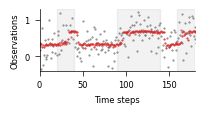

In [ ]:
_use_oracle = False
_use_optimized_thalamus = False
config= Config(env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std}, 'gauss2': {'mean': default_mean2, 'std': default_std},})
scale = 10
training_phase_1_config = {'context_transition_function':'geometric',
    'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
    'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': 8}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
logger.experiment_name = f'quantifying_generalization_{_use_oracle}'

test_env = Generative_environment(config, experiment=1, novel_mean=default_mean2) # it will use the novel_mean as the mean of the second gaussian
horizon =5
optimizer = torch.optim.SGD([model_RNN.get_parameter('thalamus')], lr=.00050, momentum=0.5)
criterion = nn.MSELoss(reduction='sum')

test_memory_buffer, test_losses = adapt_model_v2(model_RNN, test_env, _use_oracle, config, optimizer, horizon, criterion,
    ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus)
# plot_behavior(test_memory_buffer, test_env, test_losses, config, _use_oracle )
# if _use_optimized_thalamus: plot_grads(test_memory_buffer, env, )

fig, axes = plt.subplots(1, 1, figsize=(2., 0.8), dpi=100)
ax = axes
logger = test_memory_buffer
obs = np.stack(logger.timestep_data['obs']).squeeze()
preds = np.stack(logger.timestep_data['predictions']).squeeze()
ax.plot(obs, 'o', label='obs', markersize=0.5, color=obs_color)
ax.plot(preds, 'o', label='preds', markersize=0.5, color=preds_color)
switches_ts_padded = test_env.env_logger['switches_ts'] +[logger.timestep_data['timestep_i'][-1]]
# ax.legend(loc='upper right', fontsize=6, ncol=2)
# ax.legend(fontsize=6,)# loc='upper left')#loc=(.3,1.2))
axes_labels(ax,'Time steps','Observations')
# ax.set_xticklabels([])
for i in range(0, len(switches_ts_padded)-1,  2):
    ax.axvspan(switches_ts_padded[i], switches_ts_padded[i+1], alpha=0.1, color='grey')
# ax.set_xlim(switches_ts_padded[6], switches_ts_padded[6] + 100)
ax.set_ylim(-.4, 1.3)
ax.set_xlim(0, switches_ts_padded[5])
# plot_only_behavior(memory_buffer, env, config=config, x1=0, x2=150)
# plt.savefig('./exports/behavior_RNN_updated.pdf')

### Run the context switching exp

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.


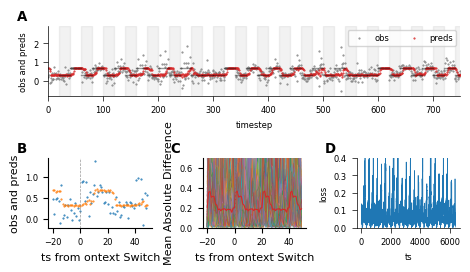

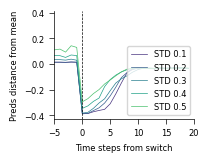

In [ ]:
memory_buffer_RNN,  losses_RNN , env_RNN= run_exp_switching_RNN(model_RNN)
switch_triggered_distance_from_mean_cortex = extract_per_std_distance_from_mean(memory_buffer_RNN, env_RNN, ts_before=20, ts_after=20)
fig, axes = plt.subplots(1, 1, figsize=(1.8, 1.4), dpi=100)
ax = axes
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cortex, ax)
# add grid lines

# plt.savefig('./exports/switching_cortex_shuffle.pdf', )

### Run some really long context blocks to histogram the obs and the RNN preds

env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1


findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.


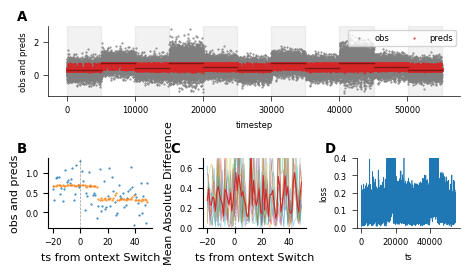

In [ ]:
memory_buffer_RNN_generalization,  losses_RNN_generalization , env_RNN_generalization= run_exp_generalization_behavior_metrics_RNN(model_RNN)
# axes[2].legend(loc='upper left', fontsize=6, ncol=1)


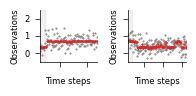

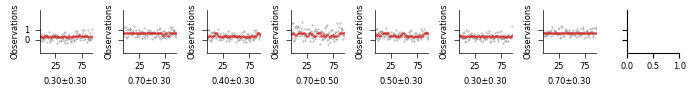

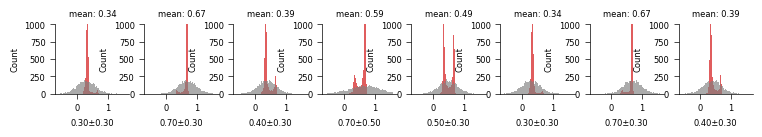

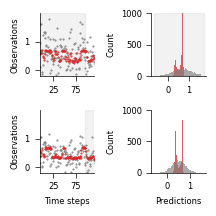

In [ ]:
plot_behavior_novel_contexts(memory_buffer_RNN_generalization, env_RNN_generalization)
# plt.savefig('./exports/behavior_RNN.pdf')
plot_histograms_novel_contexts(memory_buffer_RNN_generalization, env_RNN_generalization)
# plt.savefig('./exports/histograms_RNN_short.pdf')
plot_combined_behavior_and_histograms(memory_buffer_RNN_generalization, env_RNN_generalization, fig_height=2.2)
# plt.savefig('./exports/combined_behavior_histogram_RNN_visual.pdf')

In [ ]:
switches = np.array(env_RNN.env_logger['switches_ts'])
# context names at switches
context_names = np.array(memory_buffer_RNN.timestep_data['context_names'])
# the env_kwargs of the context names at switches
for i, switch in enumerate(switches):
    m = (env_RNN.envs[context_names[switch]]['kwargs']['mean'])
    # print (f'context {i} mean: {m}')

(1198.0, 1400.0)

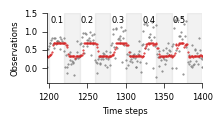

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2., 0.9), )#dpi=100)
x1  = 1198
x2 = 1400
logger = memory_buffer_RNN
env = env_RNN
obs = np.stack(logger.timestep_data['obs']).squeeze()
preds = np.stack(logger.timestep_data['predictions']).squeeze()
ax.plot(obs, 'o', label='obs', markersize=0.5, color=obs_color)
if preds.shape[-1] == 2: # if there are two preds, plot both in different colors
    ax.plot(preds, 'o', label='preds', markersize=0.5)
else:
    ax.plot(preds, 'o', label='preds', markersize=0.5, color=preds_color)

switches_ts_padded = env.env_logger['switches_ts'] +[logger.timestep_data['timestep_i'][-1]]
for i, switch in enumerate(switches_ts_padded[:-1]):
    if i%2 == 0:
        ax.axvspan(switches_ts_padded[i], switches_ts_padded[i+1], alpha=0.1, color='grey')
    # env_key = list(env.envs.keys())[i%2]
    env_key = logger.timestep_data['context_names'][switches_ts_padded[i]]
    mean = env.envs[env_key]['kwargs']['mean']
    # // draw a line at the mean of the current context between the context switches
    # ax.axhline(y=mean, xmin=switches_ts_padded[i]/(logger.timestep_data['timestep_i'][-1]), xmax=switches_ts_padded[i+1]/logger.timestep_data['timestep_i'][-1], color='black', linewidth=0.5, alpha=0.5)
    # ax.plot([switches_ts_padded[i], switches_ts_padded[i+1]] , [mean,mean],
        # color='black',linestyle='-', linewidth=1, alpha=0.4)
    # use text to write STD of the current context in each context block
    
    if switches_ts_padded[i] > x1 and switches_ts_padded[i] < x2 and i%2 ==1:
        ax.text(s=f'{env.envs[env_key]["kwargs"]["std"]}', x=(switches_ts_padded[i]+switches_ts_padded[i+1])/2, y=1.3, fontsize=6, horizontalalignment='center', verticalalignment='center')
axes_labels(ax,'Time steps','Observations')
ax.set_ylim(-.4, 1.5)    
ax.set_xlim([x1,x2])
# plt.savefig('./exports/behavior_RNN_switches.pdf')

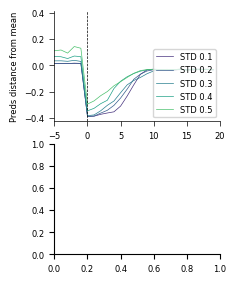

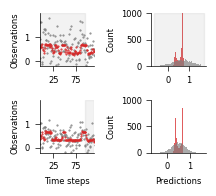

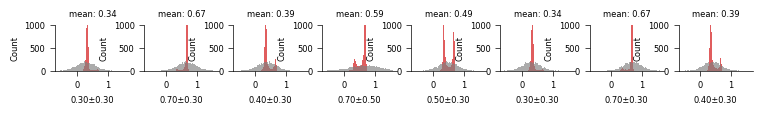

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=[5.4/2.53, 8/2.53], dpi=100)
ax = axes[0]
plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean_cortex, ax)
# plt.savefig('./exports/switching_cortex_shuffle_07_03.pdf',)
ax = axes[1]
# fig.tight_layout()
# plot_all_generalization_lines(memory_buffers_RNN_generalization_all , envs_RNN_generalization_all, ax, title='RNN', stds=stds, means=means)
# plt.savefig('./exports/behavior_RNN_cxt_var.pdf')
plot_combined_behavior_and_histograms(memory_buffer_RNN_generalization, env_RNN_generalization, fig_height=2.0, ylim=1000)
# plt.savefig('./exports/combined_behavior_histogram_RNN_CL.pdf')
plot_histograms_novel_contexts(memory_buffer_RNN_generalization, env_RNN_generalization, fig_height=.6)
# plot_histograms_novel_contexts(memory_buffer_RNN_generalization, env_RNN_generalization)
# plt.savefig('./exports/histograms_RNN_short_CL.pdf')

**Multiple seeds**

In [ ]:
# Train RNN
# config = Config(env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std}, 'gauss2': {'mean': default_mean2, 'std': default_std},})
# # config = generalization_mean_and_var_Config (env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': 0.1},
# #                 'gauss2': {'mean': default_mean2, 'std': 0.1}, 'gauss3': {'mean': default_mean1, 'std': 0.3},
# #                  'gauss3': {'mean': default_mean2, 'std': 0.3}}, context_units=2)

# scale = 10
# training_phase_1_config = {'context_transition_function':'geometric',
#         'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
#         'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':80}
# config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
# train_steps = int(100 * scale)
# logger = Logger(config)
# logger.experiment_name = f'generative_1d_2gaussians_oracle_{float(config.use_oracle)}'
# env = Generative_environment(config)
# model = LSTM_model(config,hidden_size=100)
# WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
# ts_in_training= 0
# horizon = 5

# _use_oracle = False
# memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
# plot_behavior(memory_buffer, env, losses, config, _use_oracle )

In [ ]:

# Train RNN
def train_cortex_only_rnn(no_of_blocks = 200, shuffle_data = True, scale=10, show_behavior=False, default_std = 0.3 ):
        default_mean1 = 0.3
        default_mean2 = 0.7
        # default_std = 0.4
        default_std_novel = default_std
        config = generalization_mean_and_var_Config (env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std},
                        'gauss2': {'mean': default_mean2, 'std': default_std}, 'gauss3': {'mean': default_mean1, 'std': default_std_novel},
                        'gauss3': {'mean': default_mean2, 'std': default_std_novel}}, context_units=2)
        # config = Config(env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std}, 'gauss2': {'mean': default_mean2, 'std': default_std},})
        config.default_mean1 = default_mean1
        config.default_mean2 = default_mean2
        config.default_std = default_std
        training_phase_1_config = {'context_transition_function':'geometric',
                'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
                'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':no_of_blocks} #40
        config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
        train_steps = int(100 * scale)
        logger = Logger(config)
        logger.experiment_name = f'generative_1d_2gaussians_oracle_{float(config.use_oracle)}'
        env = Generative_environment(config, experiment=1)#, novel_mean=0.7, novel_std=0.3)
        model_RNN = LSTM_model(config,hidden_size=100)
        WU_optimizer = optim.Adam(model_RNN.parameters(), lr=0.001)
        ts_in_training= 0
        horizon = 5
        _use_oracle = False
        if shuffle_data:
                memory_buffer, losses = adapt_model_v2_shuff_new_baseline(model_RNN, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
        else:
                memory_buffer, losses = adapt_model_v2(model_RNN, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
        if show_behavior:
                plot_behavior(memory_buffer, env, losses, config, _use_oracle )
        return memory_buffer, losses, env, model_RNN, config

def disconnect_model(model_RNN):
        try:
                # model.thalamus.shape
                model_RNN.thalamus.detach_()
                model_RNN.thalamus.requires_grad =True
                # model_RNN.thalamus.zero_grad()
                model_RNN.get_parameter('thalamus').detach_()
                model_RNN.get_parameter('thalamus').grad = torch.zeros_like(model_RNN.get_parameter('thalamus'))

                memory_buffer_RNN,  losses_RNN , env_RNN= run_exp_switching_RNN(model_RNN)
        except:
                pass
        # model.thalamus.shape
        model_RNN.thalamus.detach_()
        model_RNN.thalamus.requires_grad =True
        # model_RNN.thalamus.zero_grad()
        model_RNN.get_parameter('thalamus').detach_()
        model_RNN.get_parameter('thalamus').grad = torch.zeros_like(model_RNN.get_parameter('thalamus'))
        return model_RNN



In [ ]:
# use extract_gen_performance to get the performance of the model
memory_buffer_RNN_test, losses_RNN_test , env_RNN_test=  run_exp_test_learned_behaviors(model_RNN)
distances_from_mean,inferred_means,mean_abs_errors = extract_gen_performance(memory_buffer_RNN_test, env_RNN_test, ts_before=40, ts_after=0)
print(distances_from_mean)
print(inferred_means)

env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
defaultdict(<class 'list'>, {0.7: [0.0140384855], 0.3: [0.032160327, 0.029270792, 0.03279424]})
defaultdict(<class 'list'>, {0.7: [0.6862203], 0.3: [0.32608336, 0.31562704, 0.33139652]})


##### Trying to monitor behavior as distance from true means as a function of training blocks, but not really working. I need a better way to quantify error. Now I'm taking the last 20 preds in each block. 

In [ ]:
training_blocks_to_test = [2, 4, 7, 10, 20, 40, 80, 120, 150, ]
master_list_distances_from_mean = [] # to run several training runs and average. They will be accumulated here
for mi in range(3):
    list_distances_from_mean = []
    list_responses_mean = []
    # for each training_block value, train a model, then test it and extract_gen_performance
    for training_blocks in training_blocks_to_test:
        _,_,_, model_RNN_test, _= train_cortex_only_rnn(no_of_blocks = training_blocks, shuffle_data = True, )
        model_RNN_test = disconnect_model(model_RNN_test)
        memory_buffer_RNN_test, losses_RNN_test , env_RNN_test=  run_exp_test_learned_behaviors(model_RNN_test)
        distances_from_mean,inferred_means,mean_abs_errors = extract_gen_performance(memory_buffer_RNN_test, env_RNN_test, ts_before=40, ts_after=0)
        list_distances_from_mean.append(distances_from_mean)
        list_responses_mean.append(inferred_means)
    master_list_distances_from_mean.append(list_distances_from_mean)
# the output of print(distances_from_mean)
# print(inferred_means)  is 
# defaultdict(<class 'list'>, {0.3: [0.034444038, 0.052872002], 0.7: [0.0030982555, 0.026988382]})
# defaultdict(<class 'list'>, {0.3: [0.33444405, 0.35287204], 0.7: [0.70083535, 0.67773753]})    


env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1


env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus size-1
env_id is larger than thalamus size, setting it to thalamus si

KeyboardInterrupt: 

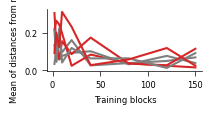

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(2., 0.8), dpi=100)

master_list_distances_from_mean_03 = []
master_list_distances_from_mean_07 = []

# for each training_blocks no exctract the mean of distances from mean for the 0.3 context and 0.7 context and plot them separately
for list_distances_from_mean in master_list_distances_from_mean:
    list_distances_from_mean_03 = []
    list_distances_from_mean_07 = []
    for distances_from_mean in list_distances_from_mean:

        list_distances_from_mean_03.append(np.mean(distances_from_mean[0.3]))
        list_distances_from_mean_07.append(np.mean(distances_from_mean[0.7]))
    master_list_distances_from_mean_03.append(list_distances_from_mean_03)
    master_list_distances_from_mean_07.append(list_distances_from_mean_07)

for list_distances_from_mean_03, list_distances_from_mean_07 in zip(master_list_distances_from_mean_03, master_list_distances_from_mean_07):    
    axes.plot(training_blocks_to_test, list_distances_from_mean_03, label='0.3', markersize=0.5, color=obs_color)
    axes.plot(training_blocks_to_test, list_distances_from_mean_07, label='0.7', markersize=0.5, color=preds_color)

# plot the mean of distances from mean for the 0.3 context and 0.7 context
axes_labels(axes,'Training blocks','Mean of distances from mean')

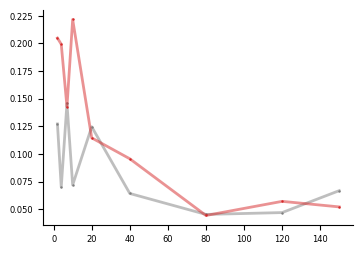

In [ ]:
# collect them, then average them and plot them
training_blocks_to_test = [2, 4, 7, 10, 20, 40, 80, 120, 150, ]
master_list_distances_from_mean_07 = np.array(master_list_distances_from_mean_07)
master_list_distances_from_mean_03 = np.array(master_list_distances_from_mean_03)

mean_distances_from_mean_07 = np.mean(master_list_distances_from_mean_07, axis=0)
mean_distances_from_mean_03 = np.mean(master_list_distances_from_mean_03, axis=0)

fig, axes = plt.subplots(1, 1, figsize=(4., 2.8), dpi=100)
axes.plot(training_blocks_to_test, mean_distances_from_mean_03, label='0.3', markersize=0.5, alpha = 0.5, color=obs_color, linewidth=2)
axes.plot(training_blocks_to_test, mean_distances_from_mean_03,  '.',label='0.3', markersize=1.5, color=obs_color, linewidth=2)
axes.plot(training_blocks_to_test, mean_distances_from_mean_07,  label='0.7', markersize=0.5, alpha = 0.5, color=preds_color, linewidth=2)
axes.plot(training_blocks_to_test, mean_distances_from_mean_07,  '.',label='0.7', markersize=1.5, color=preds_color, linewidth=2)


    

In [ ]:
def run_generalization(model_RNN):
    stds = [0.1, 0.2, 0.3, 0.4, 0.5]
    memory_buffers_RNN_generalization_all = []
    envs_RNN_generalization_all = []
    for std in stds:
        memory_buffer_RNN_generalization_all,  losses_RNN_generalization_all , env_RNN_generalization_all= run_exp_generalization_space_RNN(model_RNN, novel_std=std)
        memory_buffers_RNN_generalization_all.append(memory_buffer_RNN_generalization_all)
        envs_RNN_generalization_all.append(env_RNN_generalization_all)
    return memory_buffers_RNN_generalization_all, envs_RNN_generalization_all


In [ ]:

continual_learning = False

if continual_learning:
    training_blocks_to_test_gen = [50 ]
else:
    training_blocks_to_test_gen = [ 20, 30,40, 60, 100]

for training_blocks in training_blocks_to_test_gen:
    if continual_learning:
        _,_,_, model_RNN_test, _= train_cortex_only_rnn(no_of_blocks = training_blocks, shuffle_data = False, scale = 10, default_std = 0.3)
    else:
        _,_,_, model_RNN_test, _= train_cortex_only_rnn(no_of_blocks = training_blocks, shuffle_data = True, scale=10, default_std = 0.3)# for training_blocks in training_blocks_to_test_gen:
    
    model_RNN_test = disconnect_model(model_RNN_test)
    memory_buffers_RNN_generalization_all, envs_RNN_generalization_all = run_generalization(model_RNN_test)
    fig, axes = plt.subplots(1,1,figsize = [5/2.53, 4.5/2.53])
    plot_all_generalization_lines(memory_buffers_RNN_generalization_all, envs_RNN_generalization_all, axes, title='RNN only', stds=stds, means=means)
    axes.set_title(f'{training_blocks} training blocks')
    fig.savefig(f'./exports/cortex_only_CL_trained_generalization_30_70_{training_blocks}.pdf', bbox_inches='tight')
    plt.show()
    # del model_RNN_test, memory_buffers_RNN_generalization_all, envs_RNN_generalization_all
    plt.close('all')


env_id is larger than thalamus size, setting it to thalamus size-1


NameError: name 'run_exp_generalization_space_RNN' is not defined

: 

Below cell is the model trained in generalization_for_halassa

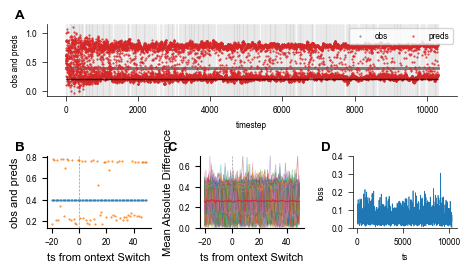

In [ ]:
# Train RNN
config = Config(env_kwargs= { 'gauss1': {'mean': 0.2, 'std': 0.2}, 'gauss2': {'mean': 0.8, 'std': 0.2},}, )
scale = 10
training_phase_1_config = {'context_transition_function':'geometric',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':400} #40
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
train_steps = int(100 * scale)
logger = Logger(config)
logger.experiment_name = f'generative_1d_2gaussians_oracle_{float(config.use_oracle)}'
env = Generative_environment(config)
model = LSTM_model(config,hidden_size=100)
WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
ts_in_training= 0
horizon = 5
criterion = nn.MSELoss()

_use_oracle = False
memory_buffer, losses = adapt_model_v2_shuff_new_baseline(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
plot_behavior(memory_buffer, env, losses, config, _use_oracle )



env_id is larger than thalamus size, setting it to thalamus size-1


/om2/user/ahummos/anaconda/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


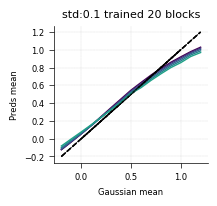

env_id is larger than thalamus size, setting it to thalamus size-1


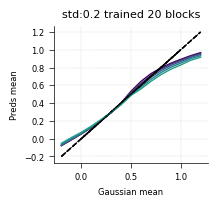

env_id is larger than thalamus size, setting it to thalamus size-1


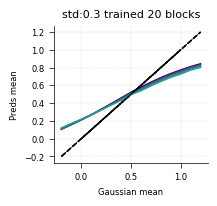

env_id is larger than thalamus size, setting it to thalamus size-1


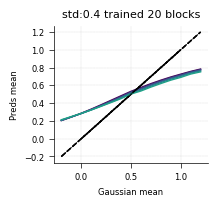

env_id is larger than thalamus size, setting it to thalamus size-1


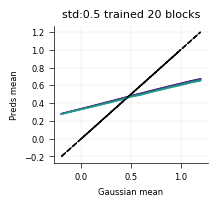

env_id is larger than thalamus size, setting it to thalamus size-1


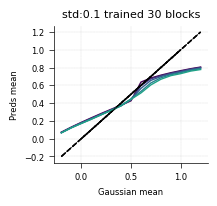

env_id is larger than thalamus size, setting it to thalamus size-1


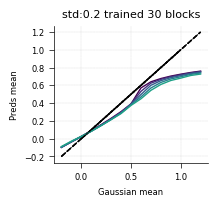

env_id is larger than thalamus size, setting it to thalamus size-1


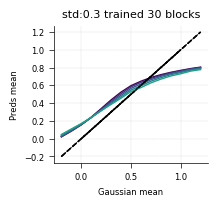

env_id is larger than thalamus size, setting it to thalamus size-1


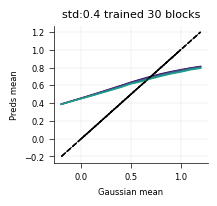

env_id is larger than thalamus size, setting it to thalamus size-1


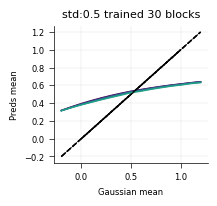

env_id is larger than thalamus size, setting it to thalamus size-1


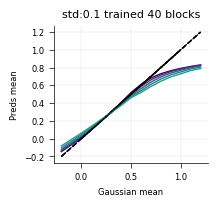

env_id is larger than thalamus size, setting it to thalamus size-1


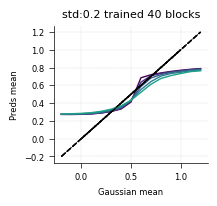

env_id is larger than thalamus size, setting it to thalamus size-1


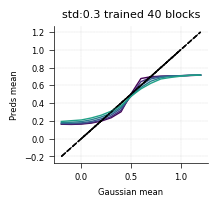

env_id is larger than thalamus size, setting it to thalamus size-1


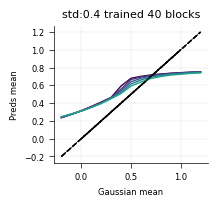

env_id is larger than thalamus size, setting it to thalamus size-1


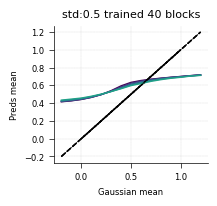

env_id is larger than thalamus size, setting it to thalamus size-1


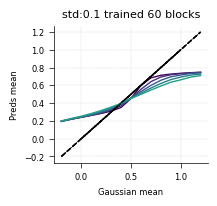

env_id is larger than thalamus size, setting it to thalamus size-1


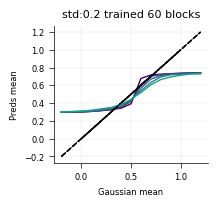

env_id is larger than thalamus size, setting it to thalamus size-1


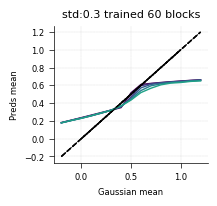

env_id is larger than thalamus size, setting it to thalamus size-1


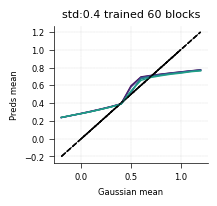

env_id is larger than thalamus size, setting it to thalamus size-1


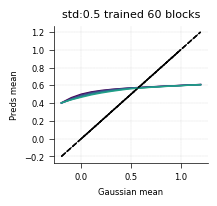

env_id is larger than thalamus size, setting it to thalamus size-1


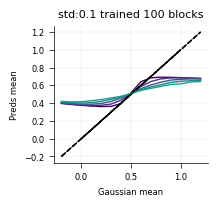

env_id is larger than thalamus size, setting it to thalamus size-1


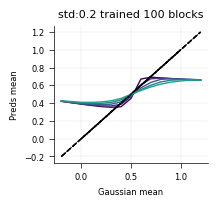

env_id is larger than thalamus size, setting it to thalamus size-1


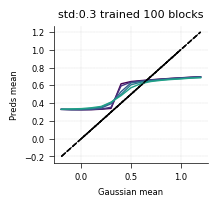

env_id is larger than thalamus size, setting it to thalamus size-1


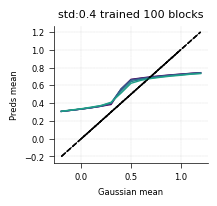

env_id is larger than thalamus size, setting it to thalamus size-1


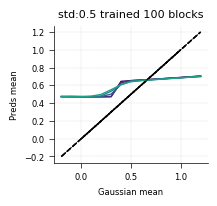

In [ ]:
## test different stds
continual_learning = False
if continual_learning:
    training_blocks_to_test_gen = [50 ]
else:
    training_blocks_to_test_gen = [ 20, 30,40, 60, 100]

training_blocks = 40
training_blocks_to_test_gen = [ 20, 30,40, 60, 100]
stds = [0.1, 0.2, 0.3, 0.4, 0.5]
for training_blocks in training_blocks_to_test_gen:
    for std in stds:
        if continual_learning:
            _,_,_, model_RNN_test, _= train_cortex_only_rnn(no_of_blocks = training_blocks, shuffle_data = False, scale = 10, default_std = std)
        else:
            _,_,_, model_RNN_test, _= train_cortex_only_rnn(no_of_blocks = training_blocks, shuffle_data = True, scale=10, default_std = std)# for training_blocks in training_blocks_to_test_gen:
        
        model_RNN_test = disconnect_model(model_RNN_test)
        memory_buffers_RNN_generalization_all, envs_RNN_generalization_all = run_generalization(model_RNN_test)
        fig, axes = plt.subplots(1,1,figsize = [5/2.53, 4.5/2.53])
        plot_all_generalization_lines(memory_buffers_RNN_generalization_all, envs_RNN_generalization_all, axes, title='RNN only', stds=stds, means=means)
        axes.set_title(f'std:{std} trained {training_blocks} blocks')
        fig.savefig(f'./exports/cortex_only_CL_trained_generalization_30_70_{std}_blocks{training_blocks}.pdf', bbox_inches='tight')
        plt.show()
        # del model_RNN_test, memory_buffers_RNN_generalization_all, envs_RNN_generalization_all
        plt.close('all')


In [ ]:
test_memory_buffer, test_losses, test_env = test_model(model_RNN, 8)

plot_behavior(test_memory_buffer, test_env, test_losses, config,  )

In [ ]:
def get_switch_triggered_mses(logger, env):
    ''' Takes only the last ts_before timesteps before a switch to decrease the effets of adapting to the switch'''
    obs = np.stack(logger.timestep_data['obs']).squeeze()
    preds = np.stack(logger.timestep_data['predictions']).squeeze()
    switches_ts = env.env_logger['switches_ts']
    switches_ts = np.array(switches_ts)
    ts_before, ts_after = 20, 0
    mses_by_switch = []
    for i, switch in enumerate(switches_ts[1:]): # ignore the first and last switch
        if len (obs[switch-ts_before:switch+ts_after]) == ts_before+ts_after: # ensure enough data.
        # mses.append(np.abs((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after])))
            mean_squared_error = np.mean((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after])**2)
            mses_by_switch.append(mean_squared_error)
    mses_by_switch = np.array(mses_by_switch)
    return mses_by_switch


In [ ]:
loss_across_seeds_lstm = []
switch_triggered_across_seeds_lstm = []
for seed in range(10):
    config = Config()
    config.seed = seed
    logger = Logger(config)
    logger.experiment_name = f'seeds_{float(config.seed)}'
    env = Generative_environment(config)
    model = LSTM_model(config,hidden_size=100)
    WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
    horizon = 5
    _use_oracle = False
    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
    loss_across_seeds_lstm.append(losses)
    switch_triggered_across_seeds_lstm.append(get_switch_triggered_mses(memory_buffer, env))
min_length = min([len(loss) for loss in loss_across_seeds_lstm])
loss_across_seeds_lstm = [loss[:min_length] for loss in loss_across_seeds_lstm]
loss_across_seeds_lstm = np.array(loss_across_seeds_lstm)

loss_across_seeds_gin = []
switch_triggered_across_seeds_gin = []
for seed in range(5):
    config = Config()
    config.seed = seed
    logger = Logger(config)
    logger.experiment_name = f'seeds_{float(config.seed)}'
    env = Generative_environment(config)
    model = LSTM_model(config,hidden_size=100)
    WU_optimizer = optim.Adam(model.parameters(), lr=0.001)
    horizon = 5
    _use_oracle = True
    memory_buffer, losses = adapt_model_v2(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
    loss_across_seeds_gin.append(losses)
    switch_triggered_across_seeds_gin.append(get_switch_triggered_mses(memory_buffer, env))
min_length = min([len(loss) for loss in loss_across_seeds_gin])
loss_across_seeds_gin = [loss[:min_length] for loss in loss_across_seeds_gin]
loss_across_seeds_gin = np.array(loss_across_seeds_gin)

loss_mean_lstm = np.mean(loss_across_seeds_lstm, axis=0)
loss_mean_gin = np.mean(loss_across_seeds_gin, axis=0)



meta NOT subset; don't know how to subset; dropped


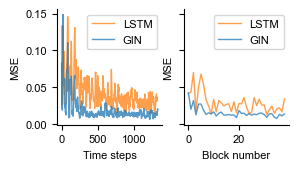

In [ ]:
# convolve the loss with a window of 10
with_context_color = 'tab:blue'
no_context_color = 'tab:orange'
window = 10
loss_mean_lstm_filtered = np.convolve(loss_mean_lstm, np.ones(window), 'valid') / window
loss_mean_gin_filtered = np.convolve(loss_mean_gin, np.ones(window), 'valid') / window

fig, axes = plt.subplots(1, 2, figsize=(3, 1.5), sharey=True, dpi=100)
# plot the loss
ax = axes[0]
ax.plot(loss_mean_lstm_filtered, label='LSTM', linewidth=1, color = no_context_color, alpha=0.75)
ax.plot(loss_mean_gin_filtered, label='GIN', linewidth=1, color = with_context_color, alpha=0.75)
ax.legend()
# ax.set_title('Loss across seeds')
ax.set_xlabel('Time steps')
ax.set_ylabel('MSE')
ax.label_outer()

ax = axes[1]
ax.label_outer()
# convolve switch triggered loss with a window of 10
window = 1
switch_triggered_across_seeds_lstm = np.array(switch_triggered_across_seeds_lstm)
switch_triggered_across_seeds_lstm_filtered = np.convolve(np.mean(switch_triggered_across_seeds_lstm, axis=0), np.ones(window), 'valid') / window
switch_triggered_across_seeds_gin = np.array(switch_triggered_across_seeds_gin)
switch_triggered_across_seeds_gin_filtered = np.convolve(np.mean(switch_triggered_across_seeds_gin, axis=0), np.ones(window), 'valid') / window

ax.plot(switch_triggered_across_seeds_lstm_filtered, label='LSTM', linewidth=1, color = no_context_color, alpha=0.75)
ax.plot(switch_triggered_across_seeds_gin_filtered, label='GIN', linewidth=1, color = with_context_color, alpha=0.75)
ax.legend()
# ax.set_title('Switch triggered loss across seeds')
ax.set_xlabel('Block number')
ax.set_ylabel('MSE')
# plt.savefig('./exports/cortex_only_learning_losses.pdf', bbox_inches='tight')

In [ ]:
# # run a quick test on a model 
# def test_model(model, no_of_blocks):
#     config= Config(env_kwargs= { 'gauss1': {'mean': default_mean1, 'std': default_std}, 'gauss2': {'mean': default_mean2, 'std': default_std},})
#     scale = 10
#     training_phase_1_config = {'context_transition_function':'geometric',
#         'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
#         'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks': no_of_blocks}
#     config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
#     logger = Logger(config)
#     test_env = Generative_environment(config, experiment=1, novel_mean=default_mean2) # it will use the novel_mean as the mean of the second gaussian
#     horizon =10
#     optimizer = torch.optim.SGD([torch.nn.Parameter(torch.zeros(1, 1, 2))], lr=0, momentum=0.5)
#     criterion = nn.MSELoss(reduction='sum')
#     test_memory_buffer, test_losses = adapt_model_v2(model_RNN, test_env, False, config, optimizer, horizon, criterion,
#         0, logger, _use_optimized_thalamus=False)
#     return test_memory_buffer, test_losses, test_env
# test_memory_buffer, test_losses, test_env = test_model(model_RNN, 8)
# # define a torch Parameter
# # thalamus = 

In [ ]:
if False:
    import gc

    # lrs = [0.4, 0.2,]
    lrs = [ 0.1, 0.4, ]
    momentums = [0.0, 0.1,  0.2, ]
    gradient_clippings = [0.0, 10.0]
    l2_losses = [0.03, 0.05, 0.2]
    total = len(lrs)*len(momentums)*len(gradient_clippings)*len(l2_losses)
    print(f'Total number of experiments: {total}')

    os.makedirs('./exports/var_grid2', exist_ok=True)

    for lr in lrs:
        for momentum in momentums:
            for gradient_clipping in gradient_clippings:
                for l2_loss in l2_losses:
                    memory_buffer_RNN_cxt_var,  losses_RNN_cxt_var , env_RNN_cxt_var= run_exp_switching_RNN_Cxt_var(model, _use_optimized_thalamus=True, lr=lr, momentum=momentum, gradient_clipping=gradient_clipping, l2_loss=l2_loss)
                    plt.savefig(f'./exports/var_grid2/switching_lr={lr}, momentum={momentum}, gradient_clipping={gradient_clipping}, l2_loss={l2_loss}_behavior.png')
                    switch_triggered_distance_from_mean = extract_per_std_distance_from_mean(memory_buffer_RNN_cxt_var, env_RNN_cxt_var, ts_before=20, ts_after=40)
                    fig, axes = plt.subplots(1, 1, figsize=(3., 2.8), dpi=140)
                    ax = axes
                    # also save to disk the switch triggered distance from mean

                    np.save(f'./exports/var_grid2/switch_triggered_distance_from_mean_lr={lr}, momentum={momentum}, gradient_clipping={gradient_clipping}, l2_loss={l2_loss}.npy', switch_triggered_distance_from_mean)
                    plot_switch_triggered_per_std_distance_from_mean(switch_triggered_distance_from_mean, ax, params=f'lr={lr}, mom={momentum}, gc={gradient_clipping}, l2={l2_loss}')
                    plt.savefig(f'./exports/var_grid2/switching_lr={lr}, momentum={momentum}, gradient_clipping={gradient_clipping}, l2_loss={l2_loss}.png')
                    plt.close('all')
                    plt.clf()
                    plt.cla()
                    gc.collect()
                    torch.cuda.empty_cache()
                    print(f'lr={lr}, momentum={momentum}, gradient_clipping={gradient_clipping}, l2_loss={l2_loss}')
